In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../')
from cnn.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from cnn.imagenet_classes import class_names
from cnn.vgg16 import VGG16

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
patch_size = 16
stride = 2

In [8]:
# torch.cuda.synchronize()
prev_time = time.time()
x = full_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index, batch_size=128)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 31.5325829983


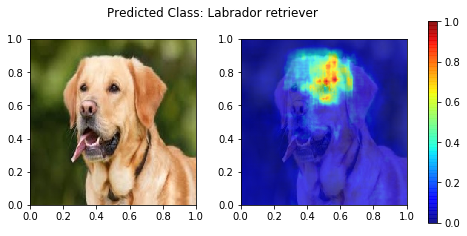

In [13]:
orig_hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])

output = open('temp', 'w')
pickle.dump(orig_hm, output)

In [14]:
gc.collect()
torch.cuda.empty_cache()

In [15]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    torch.cuda.synchronize()
    if not adaptive:
        x = inc_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=256, beta=beta)
    else:
        x = adaptive_drilldown(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=256, beta=beta, percentile=20)
    
    torch.cuda.synchronize()

    return x

### Patch growth thresholding

BETA: 1.0 Inference Time: 6.37414288521


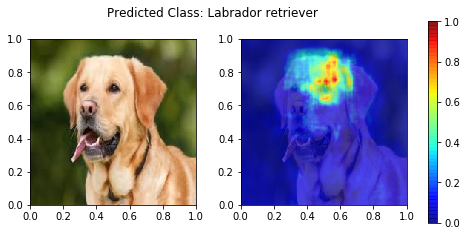

BETA: 0.9 Inference Time: 6.08324503899


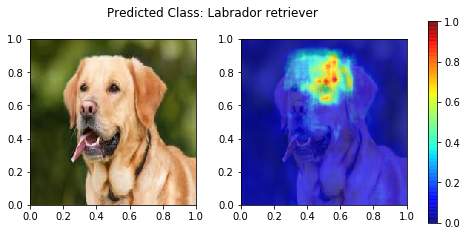

BETA: 0.8 Inference Time: 6.00031995773


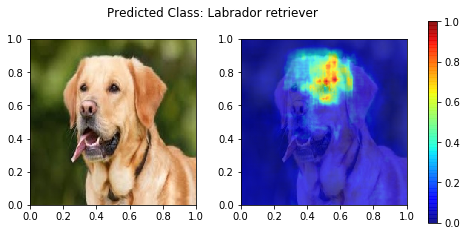

BETA: 0.7 Inference Time: 5.96660804749


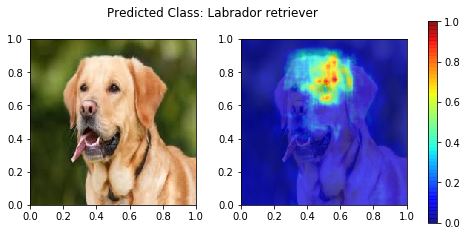

BETA: 0.6 Inference Time: 5.8660838604


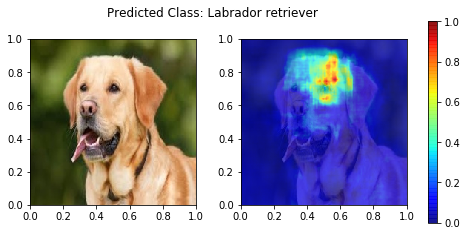

BETA: 0.5 Inference Time: 5.72268390656


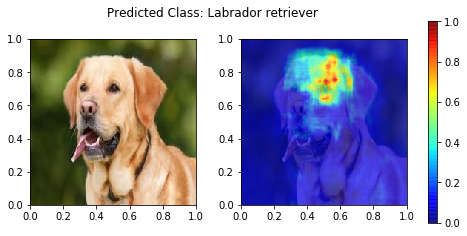

BETA: 0.4 Inference Time: 4.99809598923


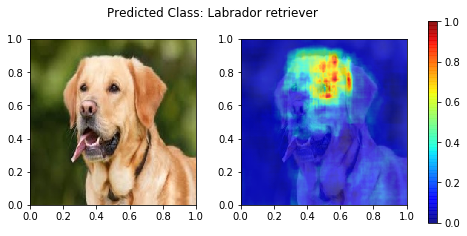

BETA: 0.3 Inference Time: 4.41623997688


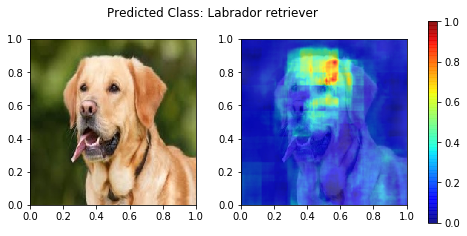

BETA: 0.2 Inference Time: 3.66009712219


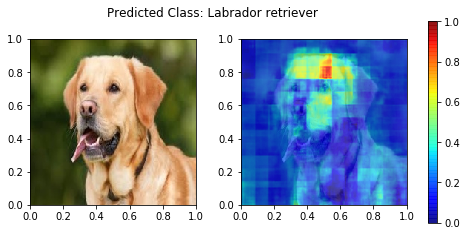

In [16]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

Text(0,0.5,'SSIM')

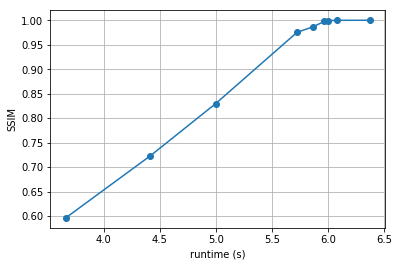

In [17]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')

BETA: 1.0 Inference Time: 5.89209198952


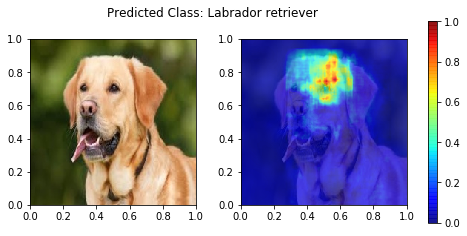

BETA: 0.9 Inference Time: 5.66717600822


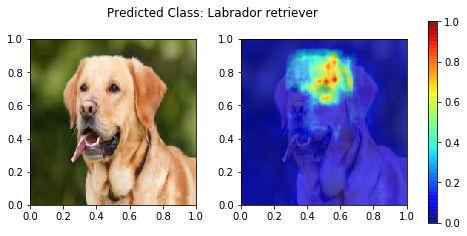

BETA: 0.8 Inference Time: 5.5775949955


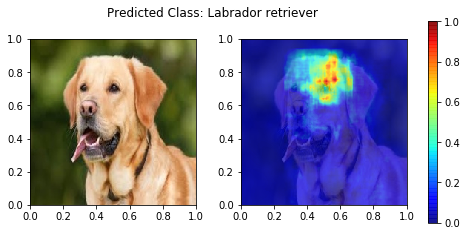

BETA: 0.7 Inference Time: 5.34960603714


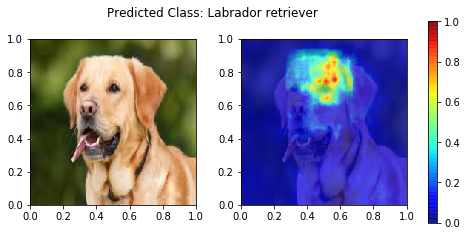

BETA: 0.6 Inference Time: 5.1451189518


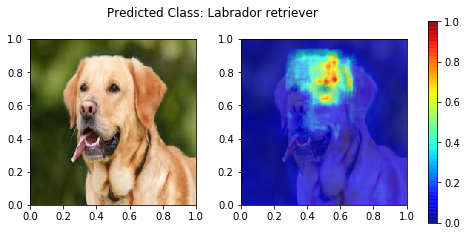

BETA: 0.5 Inference Time: 5.27282714844


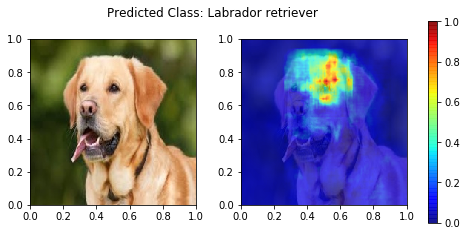

BETA: 0.4 Inference Time: 4.87910103798


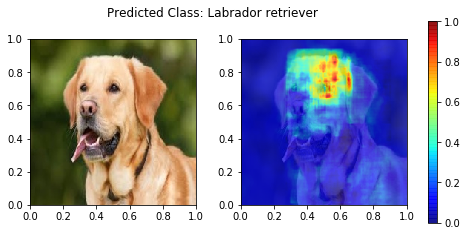

BETA: 0.3 Inference Time: 4.61904096603


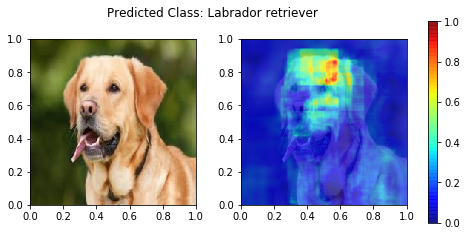

BETA: 0.2 Inference Time: 4.53820586205


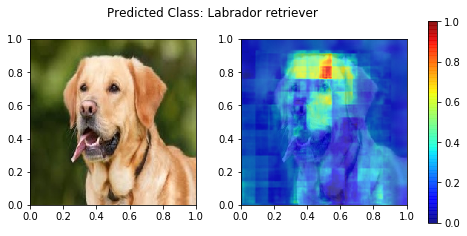

In [18]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

Text(0,0.5,'SSIM')

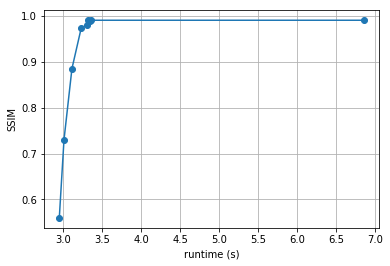

In [5]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')